In [1]:
# Install required packages
!pip install colpali-engine qdrant-client stamina tqdm ollama requests

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.4/266.4 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
  Created wheel

In [2]:
import os
from typing import cast, List
import torch
from PIL import Image
from colpali_engine.models import ColPali, ColPaliProcessor
from qdrant_client import QdrantClient, models
import stamina
from tqdm import tqdm
import requests as requests
import json

In [3]:
def get_image_paths(folder_path):
  images_paths = [folder_path+'/'+file for file in os.listdir(folder_path)]
  return images_paths

In [4]:
image_paths = get_image_paths('/content/image_dataset')
print(f"Number of images in the folder: {len(image_paths)}")

Number of images in the folder: 50


In [5]:
def load_image_embedding_model(model_name):
  model = ColPali.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      device_map="cuda:0",  # or "mps" if on Apple Silicon
  ).eval()

  processor = ColPaliProcessor.from_pretrained(model_name)

  return model, processor

In [6]:
model, processor = load_image_embedding_model("vidore/colpali-v1.2")

adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [7]:
def load_images(image_paths: List[str]) -> List[Image.Image]:
    images = []
    for path in image_paths:
        try:
            img = Image.open(path)
            img = img.convert("RGB")
            images.append(img)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return images

In [8]:
images = load_images(image_paths)

In [9]:
print(len(image_paths))

50


In [10]:
# qdrant connection details
qdrant_url = "https://5655a152-5dfa-4807-9700-f8976170b86f.europe-west3-0.gcp.cloud.qdrant.io:6333"
qdrant_api = "ehg5LrM1GG9BLJ9ShL6hBWH5IGxsD7RJHXNogiJQfiYD-5gONEN5CQ"

In [11]:
def create_qdrant_client(url, api_key):
  qdrant_client = QdrantClient(
      url=url,
      api_key=api_key,
  )
  return qdrant_client

def delete_qdrant_collection(qdrant_client, collection_name):
  qdrant_client.delete_collection(collection_name=collection_name)

In [12]:
qdrant_client = create_qdrant_client(qdrant_url, qdrant_api)

In [ ]:
# delete_qdrant_collection(qdrant_client, collection_name="osc_image_embeddings_v1")

In [13]:
print(qdrant_client.get_collections())

collections=[CollectionDescription(name='osc_image_embeddings_v1'), CollectionDescription(name='cybersec_image_embeddings_v1')]


In [14]:
def create_qdrant_collection(qdrant_client, collection_name, vector_size, indexing_threshold):
  qdrant_client.create_collection(
      collection_name=collection_name,
      on_disk_payload=True,
      optimizers_config=models.OptimizersConfigDiff(
          indexing_threshold=indexing_threshold
      ),
      vectors_config=models.VectorParams(
          size=vector_size,
          distance=models.Distance.COSINE,
          multivector_config=models.MultiVectorConfig(
              comparator=models.MultiVectorComparator.MAX_SIM
          ),
          quantization_config=models.ScalarQuantization(
              scalar=models.ScalarQuantizationConfig(
                  type=models.ScalarType.INT8,
                  quantile=0.99,
                  always_ram=True,
              ),
          ),
      ),
  )

In [ ]:
# Create qdrant collection with multivector configuration
collection_name = "osc_image_embeddings_v1"
vector_size = 128
indexing_threshold = 200
create_qdrant_collection(qdrant_client, collection_name, vector_size, indexing_threshold)

In [15]:
print(qdrant_client.get_collections())

collections=[CollectionDescription(name='osc_image_embeddings_v1'), CollectionDescription(name='cybersec_image_embeddings_v1')]


In [16]:
@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(points, collection_name):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

In [17]:
def index_images_to_qdrant(images_paths, batch_size, collection_name):
  # Use tqdm to create a progress bar
  with tqdm(total=len(images_paths), desc="Indexing Progress") as pbar:
      for i in range(0, len(images_paths), batch_size):
          batch = images_paths[i : i + batch_size]

          images = load_images(batch)
          # Process and encode images
          with torch.no_grad():
              batch_images = processor.process_images(images).to(
                  model.device
              )
              image_embeddings = model(**batch_images)

          # Prepare points for Qdrant
          points = []
          for j, embedding in enumerate(image_embeddings):
              # Convert the embedding to a list of vectors
              multivector = embedding.cpu().float().numpy().tolist()
              points.append(
                  models.PointStruct(
                      id=i + j,  # we just use the index as the ID
                      vector=multivector,  # This is now a list of vectors
                      payload={
                          "image": batch[j]
                      },
                  )
              )


          try:
              upsert_to_qdrant(points, collection_name)
          except Exception as e:
              print(f"Error during upsert: {e}")
              continue
          pbar.update(batch_size)

  print("Indexing complete!")

In [ ]:
index_images_to_qdrant(image_paths, 2, collection_name)

Indexing Progress: 142it [09:03,  3.83s/it]

Indexing complete!


In [18]:
# Search functionality
def search_images_by_text(query_text, collection_name, top_k=5):
    # Process and encode the text query
    with torch.no_grad():
        batch_query = processor.process_queries([query_text]).to(
            model.device
        )
        query_embedding = model(**batch_query)

    # Convert the query embedding to a list of vectors
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    # Search in Qdrant
    search_result = qdrant_client.query_points(
        collection_name=collection_name, query=multivector_query, with_payload=["image"], limit=top_k
    )

    row_image_paths = [r.payload["image"] for r in search_result.points]
    return row_image_paths

In [19]:
def display_retrieved_images(image_paths):
  for image_path in image_paths:
    print(image_path)
    image = load_images([image_path])[0]
    display(image)

In [20]:
import base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

In [21]:
# Ollama Llava testing
from ollama import Client
import requests

In [28]:
ollama_client = Client(host='http://156.56.180.239:11434')
llama_url = "https://holdzo6ho53kem-8000.proxy.runpod.net/predict"

In [25]:
def generate_response(user_query, encoded_images, model_name):
  if model_name == 'ollama-llava':
    response = ollama_client.chat(model='llava', messages=[
      {
        'role': 'user',
        'content': user_query,
        "images":encoded_images
      },
    ])

    print(response['message']['content'])
  elif model_name == 'llama_3.2_vision':
    data = {
        "image_base64": encoded_images[0],
        "user_query": user_query
    }

    response = requests.post(llama_url, data=json.dumps(data))
    output_text = response.json()['output']
    assistant_answer = output_text.split('assistant\n\n')[1]
    print(assistant_answer)
  else:
    print("Invalid model name provided!")


In [61]:
# user_query = "How does shared memory work between two processes using memory-mapped files?"
# user_query = "What is the data transfer speed of PCI Express Gen 3 compared to USB 3.0?"
# "user_query = "What is the difference in how introduced variables are used in the two parse trees shown?"
# user_query = "Who is involved in the key exchange process before encryption?"
# user_query = "What is displayed on the home screen of the iPhone in the figure?"
# user_query = "What is the difference between a singly linked list and a doubly linked list?"
# user_query = "What is the typical size range for main memory and solid-state disks"
# user_query = "What happens if the kernel I/O subsystem cannot satisfy an I/O request?"


# -- Evaluation queries --
# user_query = "In the cloud computing environment shown, what role does the load balancer play between customer requests and virtual machines?"
# user_query = "What sequence of events occurs between the CPU and the I/O device during interrupt handling, and how does the CPU alternate between user program execution and I/O interrupt processing?"
# user_query = "What is the data transfer speed of PCI Express Gen 3 compared to USB 3.0?"
user_query = "Compare the access times and typical sizes of registers, main memory, and solid-state disks. What is the main advantage of using registers over solid-state disks, and what is the main drawback?"


results_ds = search_images_by_text(user_query, "cybersec_image_embeddings_v1", 1)
print(results_ds)

result_encode_images = [encode_image(result) for result in results_ds]

['/content/image_dataset_2/Abraham-Silberschatz-Operating-System-Concepts-10th-2018_page-0059.jpg']


In [52]:
generate_response(user_query, result_encode_images, "ollama-llava")

 The image shows a binary search tree (BST) with the following elements:

- Root node value is 12.
- The left child of the root node has a value of 9.
- The right child of the root node has a value of 15.
- The left child of the 9 node has a value of 6.
- The right child of the 15 node has a value of 18.
- The left child of the 6 node does not exist, which implies it is `None` (NULL).

To search for the value 14 in this tree and determine the number of comparisons made:

1. Start at the root node (value 12).
2. Compare the value 14 with the root value 12. Since 14 is greater than 12, we move to the right child (value 15).
3. Next, compare 14 with 15. It's less than 15, so we move to the left child (value 6).
4. Compare 14 with 6. It's greater than 6, but since there is no right child from 6, the search for 14 in this tree does not result in a match.

During the search process, we made three comparisons:
- The first comparison was between the root node value (12) and the search key (14)

In [62]:
generate_response(user_query, result_encode_images, "llama_3.2_vision")

To find the solution to this question, we need to compare the access times and typical sizes of registers, main memory, and solid-state disks. 

*   **Access Times:**
    *   Registers: 0.25-0.5 ns
    *   Main Memory: 80-250 ns
    *   Solid-State Disk: 5,000,000 ns
*   **Typical Sizes:**
    *   Registers: <1 KB
    *   Main Memory: <64 GB
    *   Solid-State Disk: <1 TB

The main advantage of using registers over solid-state disks is their much faster access times, which are orders of magnitude faster than those of solid-state disks. This makes registers ideal for storing frequently accessed data that requires quick retrieval and manipulation. The main drawback of using registers is their limited size, which is typically much smaller than that of main memory or solid-state disks. This means that registers can only store a small amount of data at a time, making them less suitable for storing large amounts of data.

**Answer:** The main advantage of using registers over solid-state di

/content/osc_2_chapters/Abraham-Silberschatz-Operating-System-Concepts-10th-2018_page-0037.jpg


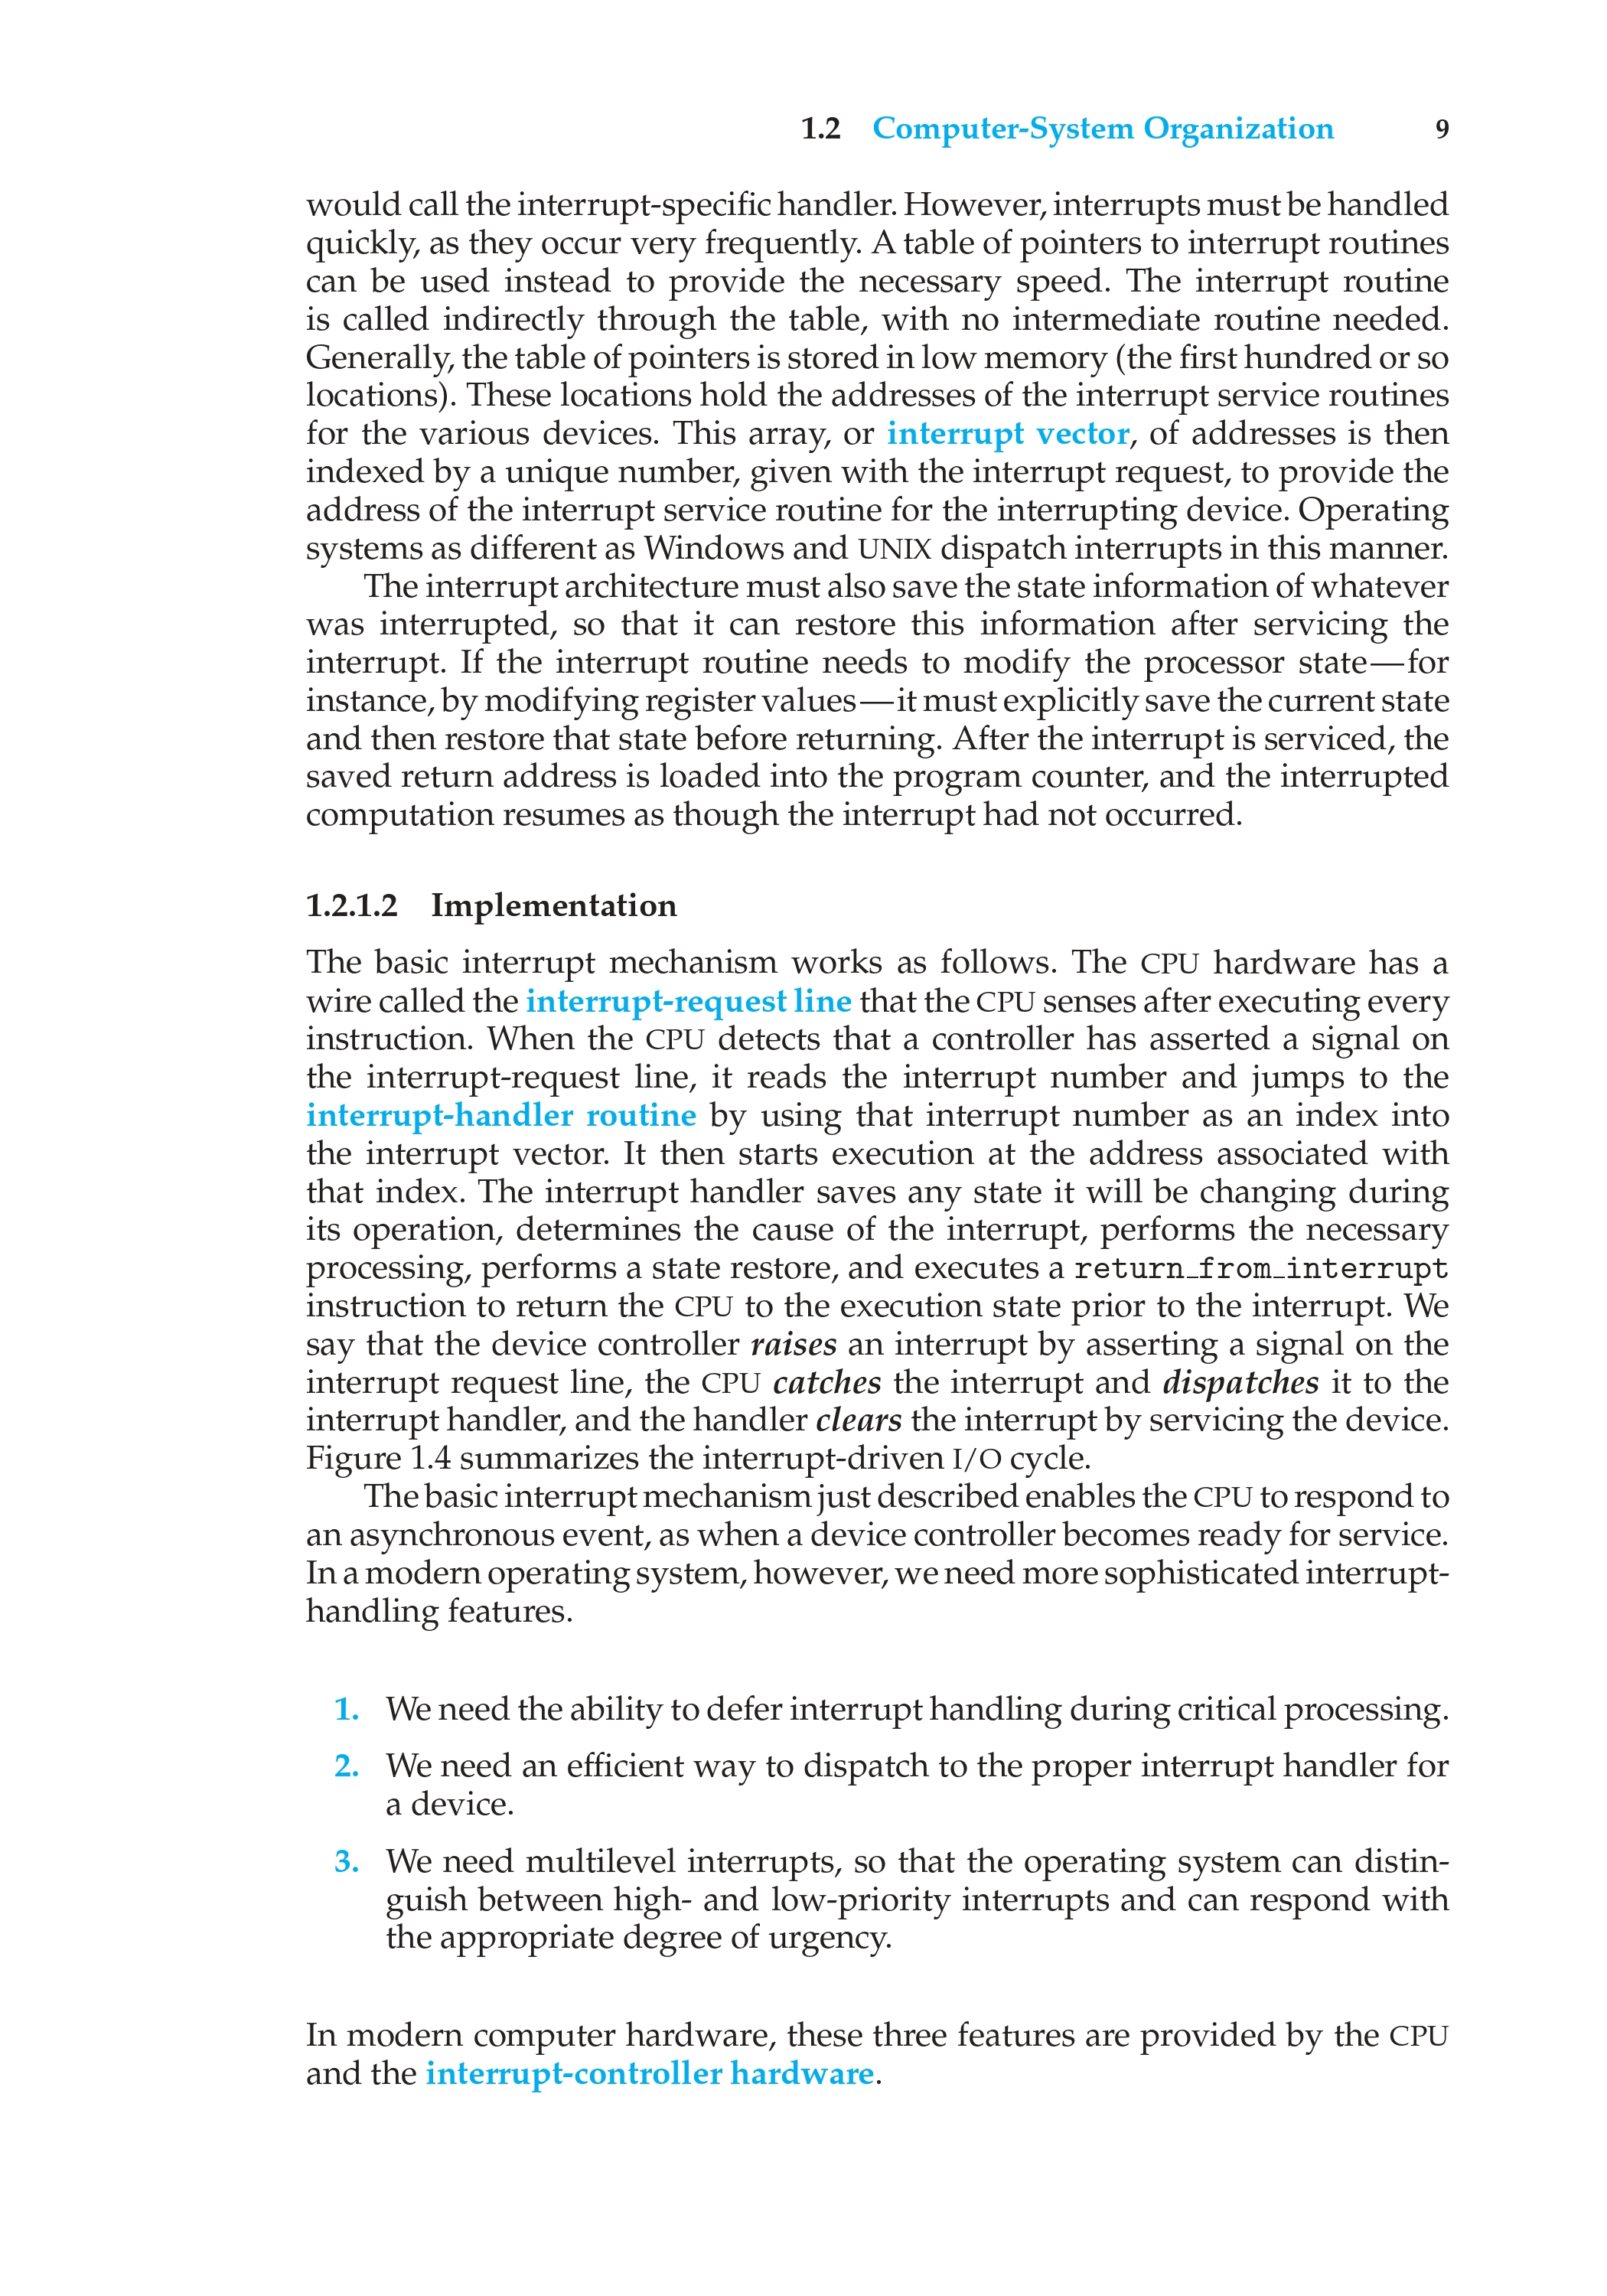

/content/osc_2_chapters/Abraham-Silberschatz-Operating-System-Concepts-10th-2018_page-0038.jpg


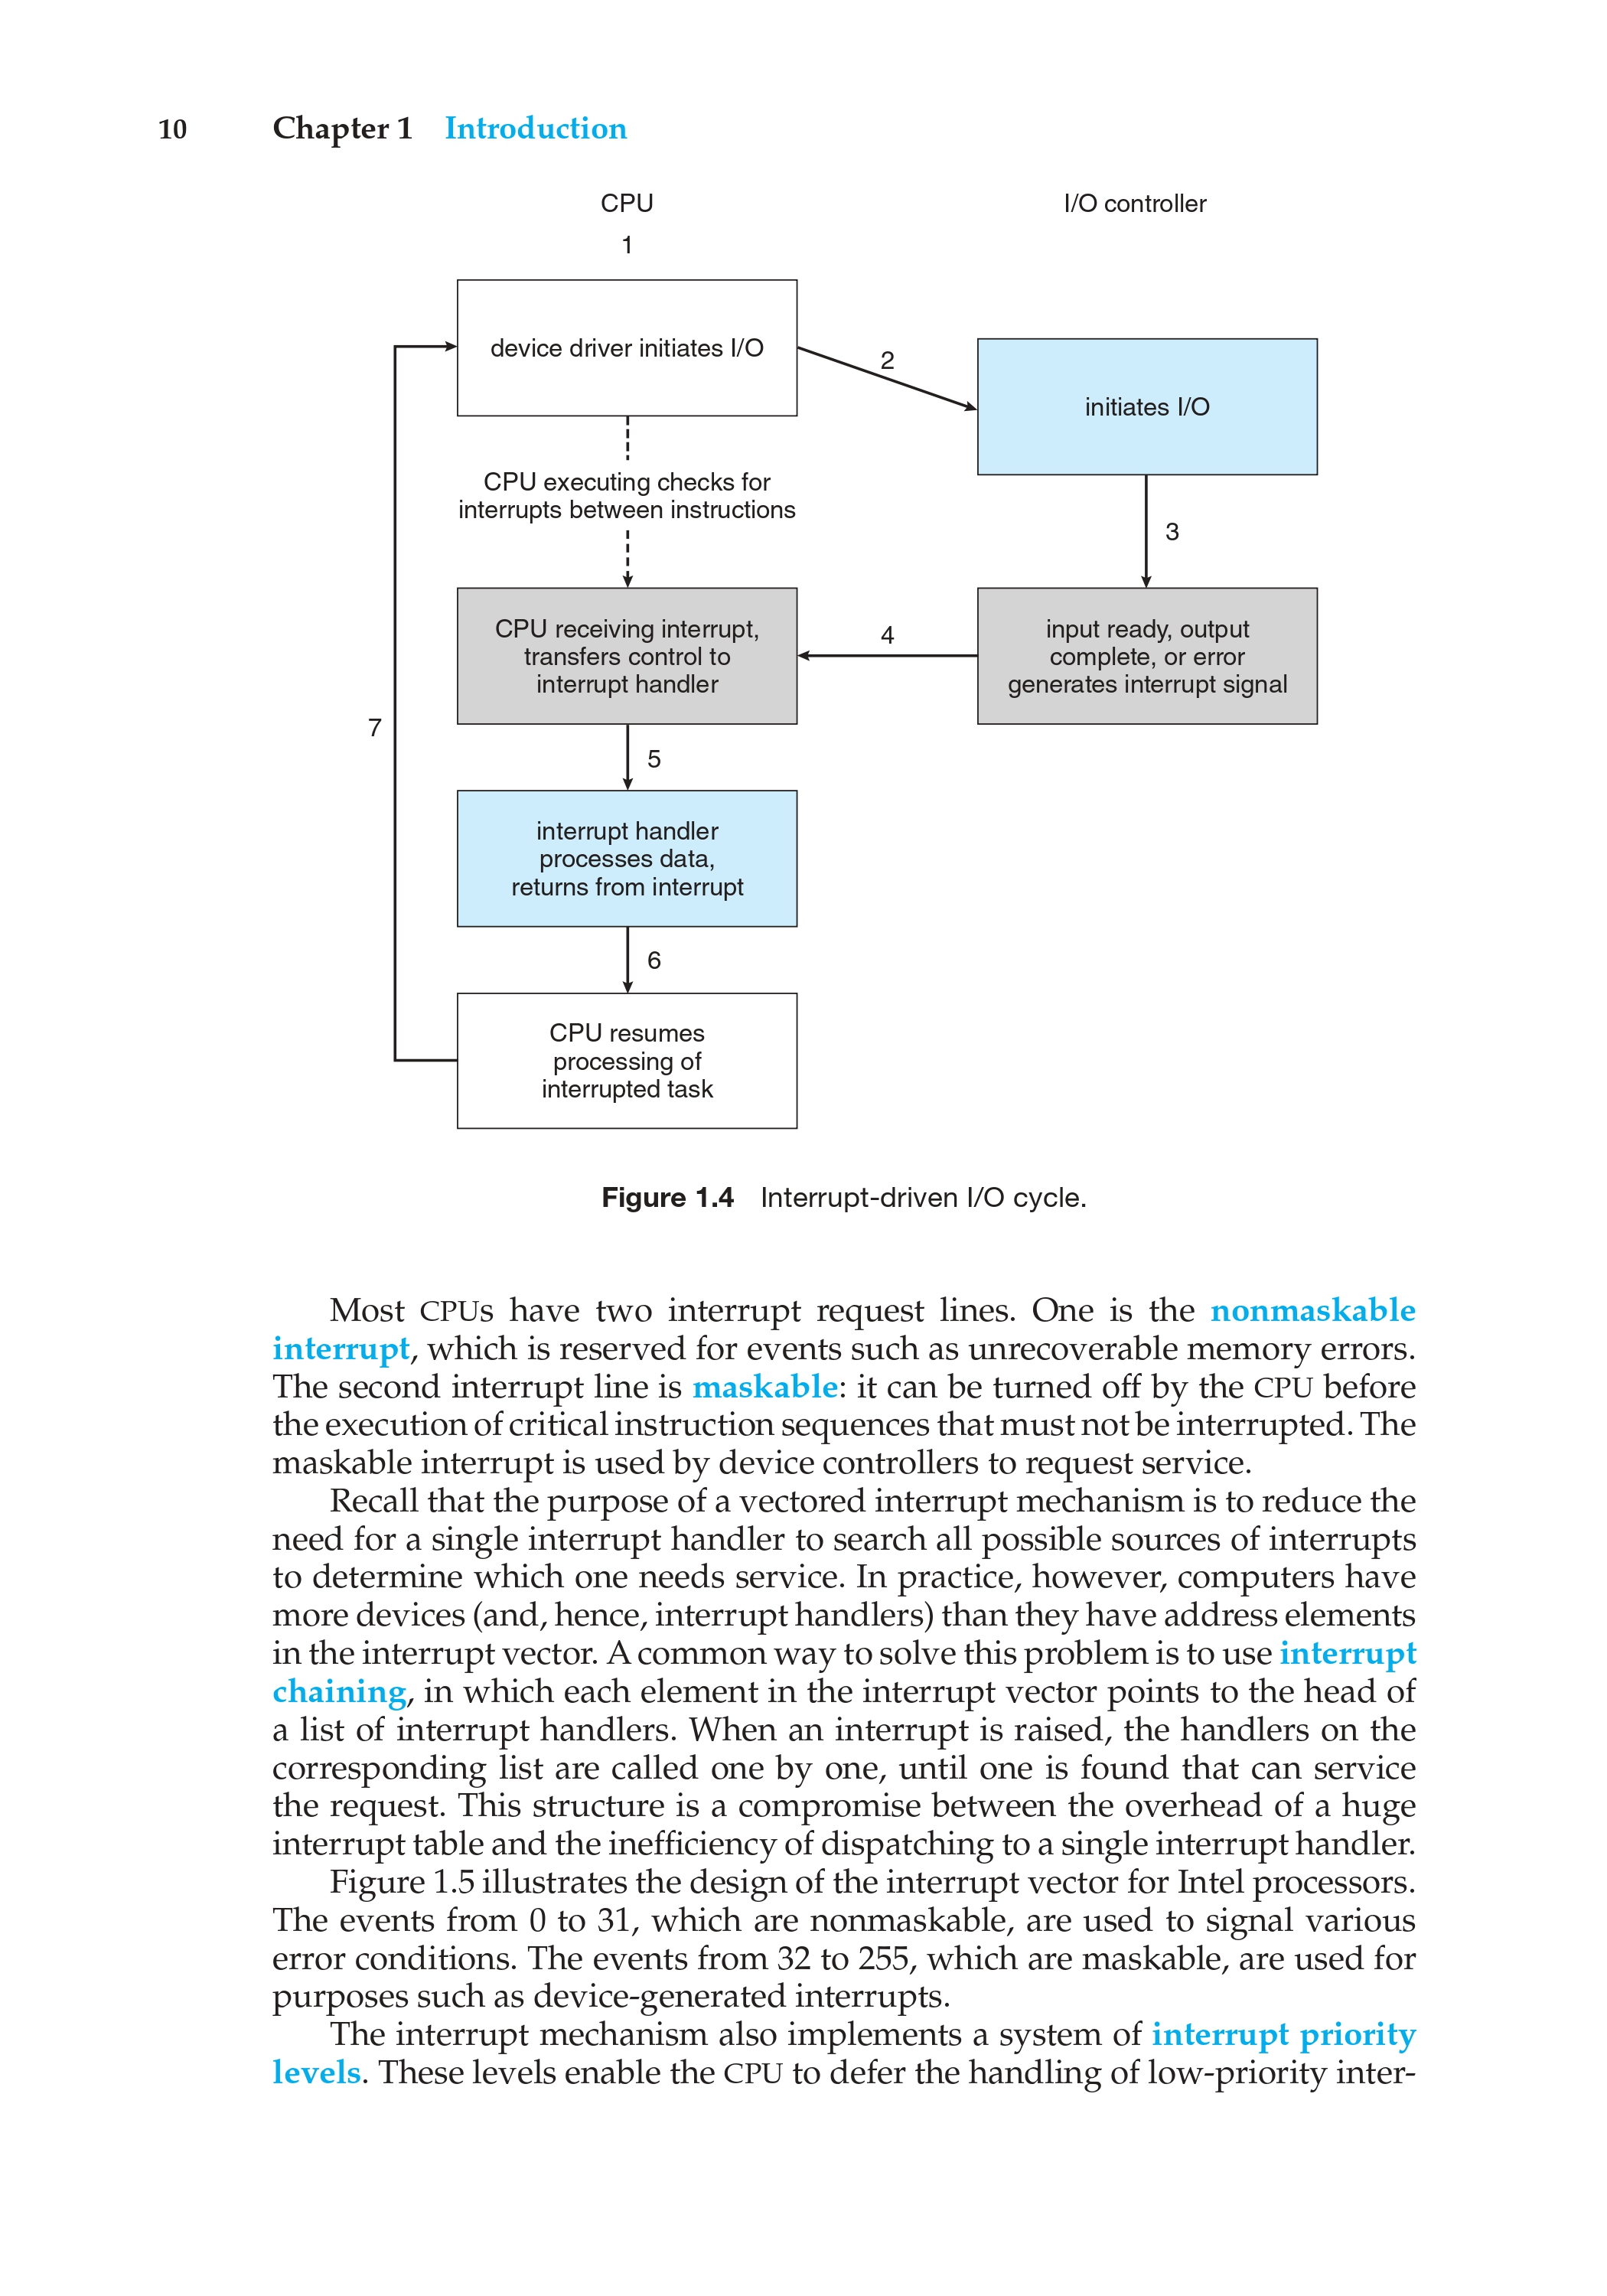

In [ ]:
# Text book search
# -- Evaluation queries --
user_query = "Referencing the diagram, explain how the basic interrupt mechanism works, detailing each step from when the device controller raises an interrupt to when the CPU resumes the interrupted task."
# user_query = "How does the speedup change with the number of processing cores for different values of S (0.05, 0.10, 0.50), and how does it compare to the ideal speedup?"

results_ds = search_images_by_text(user_query, "osc_image_embeddings_v1", 2)
display_retrieved_images(results_ds)